In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# 第一題

In [2]:
left = cv2.imread('laptop_left.png')

right = cv2.imread("laptop_right.png")

In [3]:
combine = np.hstack([left,right])

combine = cv2.cvtColor(combine, cv2.COLOR_BGR2RGB)

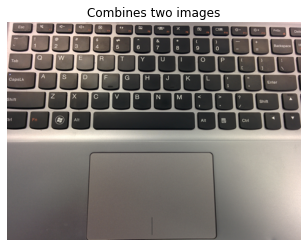

In [4]:
plt.title("Combines two images")
plt.axis("off")
plt.imshow(combine)


# 第二題

In [5]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w/2,h/2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [6]:
rotate_img = rotate(combine,-30)

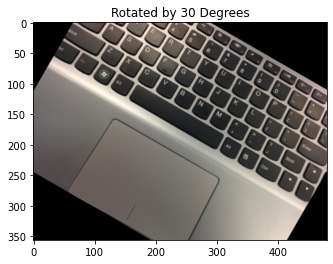

In [7]:
plt.title("Rotated by 30 Degrees")
plt.imshow(rotate_img)

# 第3題

In [8]:
lena = cv2.imread('lena_flipped.bmp')
lena = cv2.cvtColor(lena, cv2.COLOR_BGR2RGB)

(-0.5, 511.5, 511.5, -0.5)

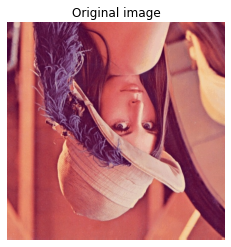

In [9]:
plt.title("Original image")
plt.imshow(lena)
plt.axis('off')

In [10]:
def rotate_90(image):    
    rotate_90_img = []
    for i in range(image.shape[0]):
        temp = []
        for j in range(image.shape[0]-1,-1,-1):
            temp.append(image[j][i])
        rotate_90_img.append(temp)
    return np.array(rotate_90_img)

In [11]:
lena_rotate_90 = rotate_90(lena)
lena_rotate_180 = rotate_90(lena_rotate_90)

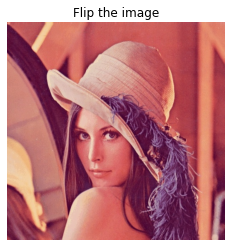

In [12]:
plt.title("Flip the image")
plt.imshow(lena_rotate_180)
plt.axis("off")
plt.savefig('flip_image.jpg')

# 第4題

In [13]:
graveler = cv2.imread("graveler.bmp")
graveler = cv2.cvtColor(graveler, cv2.COLOR_BGR2RGB)

In [14]:
class overlay():
    def __init__(self, foreground, background):
        self.foreground = foreground
        self.background = background
    def padding(self):
        self.image_padding = cv2.copyMakeBorder(self.foreground,
                (self.background.shape[0]-self.foreground.shape[0])//2,
                (self.background.shape[0]-self.foreground.shape[0]) - (self.background.shape[0]-self.foreground.shape[0])//2,
                (self.background.shape[1]-self.foreground.shape[1])//2,
                (self.background.shape[1]-self.foreground.shape[1]) - (self.background.shape[1]-self.foreground.shape[1])//2,
                cv2.BORDER_CONSTANT,
                value=[255,255,255])
    def mask(self):
        gray = cv2.cvtColor(self.image_padding, cv2.COLOR_BGR2GRAY)
        _ , self.mask = cv2.threshold(gray,250,255, cv2.THRESH_BINARY)        
    def combine(self):
        self.output = np.zeros(self.background.shape)
        for i in range(3):
            self.output[:,:,i]=np.array(self.background)[:,:,i]*(self.mask/255)+self.image_padding[:,:,i]*(1-self.mask/255)
        self.output = self.output.astype('int32')    
    def show(self):
        plt.title('Overlay image')
        plt.axis('off')
        plt.imshow(self.output)

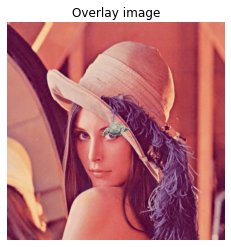

In [15]:
Overlay = overlay(graveler,lena_rotate_180) 
Overlay.padding()
Overlay.mask()
Overlay.combine()
Overlay.show()

# 第5題

$\boldsymbol{5(a)}$

In [16]:
class watermark():
    def __init__(self, mark, background,coef):
        self.mark = mark
        self.background = background
        self.coef = coef
    def padding(self):
        self.image_padding = cv2.copyMakeBorder(self.mark,
                (self.background.shape[0]-self.mark.shape[0])//2,
                (self.background.shape[0]-self.mark.shape[0]) - (self.background.shape[0]-self.mark.shape[0])//2,
                (self.background.shape[1]-self.mark.shape[1])//2,
                (self.background.shape[1]-self.mark.shape[1]) - (self.background.shape[1]-self.mark.shape[1])//2,
                cv2.BORDER_CONSTANT,
                value=[255,255,255])
    def dct(self, image):
        image_float = np.float32(image)
        image_dct = np.zeros(image.shape)
        for i in range(3):
            image_dct[:,:,i] = cv2.dct(image_float[:,:,i])
        return image_dct
    def combine(self, mark_dct, background_dct, coef):
        return mark_dct  + background_dct *coef 
    def extract(self, background_dct, embd_dct, coef):
        return embd_dct - background_dct * coef
    def idct(self, image):
        image_idct = np.zeros(image.shape)
        for i in range(3):
            image_idct[:,:,i] = cv2.idct(image[:,:,i])
        image_idct = np.int32(image_idct)
        return image_idct
    def show(self, image, title):
        plt.title(title)
        plt.axis("off")
        plt.imshow(image)
    def embd(self):
        ## embd image
        self.padding()
        mark_dct = self.dct(self.image_padding)
        self.background_dct = self.dct(self.background)
        mix = self.combine(mark_dct, self.background_dct, self.coef)
        mix_idct = self.idct(mix)
        self.embd_img = mix_idct//(self.coef+1)
        self.show(self.embd_img, 'embded')
        return self.embd_img
    def retrieve(self):
        ## retrieve image
        weight_embd_img = self.embd_img * (self.coef + 1)
        embd_dct = self.dct(weight_embd_img)
        extractor = self.extract(self.background_dct, embd_dct, self.coef)
        retrieve_idct = self.idct(extractor)
        self.show(retrieve_idct,'retrieve')

In [17]:
Watermark = watermark(graveler, lena_rotate_180,10)

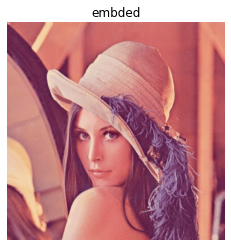

In [18]:
embd_image = Watermark.embd()

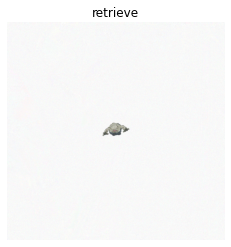

In [19]:
Watermark.retrieve()

$\boldsymbol{5(b)}$

Image compression by bit plane

In [20]:
class bit_plane():
    def __init__(self, image, plane):
        self.image = image
        self.plane = plane
        self.row, self.col,_ = self.image.shape
    def channel(self):
        self.img_r = self.image[:, :, 0]
        self.img_g = self.image[:, :, 1]
        self.img_b = self.image[:, :, 2]
    def bit_slice_comibine(self, color):
        r = np.zeros((self.row, self.col, 8), dtype = np.uint8)
        
        for i in range(8):
            x = 2 ** i
            r[:,:,i] = cv2.bitwise_and(color, x)
            mask = r[:,:,i]>0
            r2 = np.copy(r)
            r2[mask] = 255
        
        original = r[:,:,7]
        
        for i in range(8,self.plane , -1):
            original = cv2.bitwise_or(original,r[:,:,i-1])
        return original
    def psnr(self, original_image, compress_image):
        mse = sum(sum(sum((original_image - compress_image)**2)))/(self.row * self.col * 3)
        psnr = 10 * np.log10((255**2)/mse)
        return psnr
    def main(self):
        self.channel()
        img_r_compress = self.bit_slice_comibine(self.img_r)
        img_g_compress = self.bit_slice_comibine(self.img_g)
        img_b_compress = self.bit_slice_comibine(self.img_b)
        img_compress = cv2.merge([img_r_compress,img_g_compress,img_b_compress])
        psnr = self.psnr(self.image, img_compress)
        plt.imshow(img_compress)
        plt.title('The bit plane compression with {} planes'.format(8-self.plane))
        plt.axis('off')
        plt.show()
        print('PSNR = {:.3f}'.format(psnr))
        return img_compress

Retrieve the image

In [21]:
class retrieve_image():
    def __init__(self, original_image, compress_image,coef):
        self.original_image = original_image
        self.compress_image = compress_image
        self.coef = coef
    def dct(self,image):
        image_float = np.float32(image)
        image_dct = np.zeros(image.shape)
        for i in range(3):
            image_dct[:,:,i] = cv2.dct(image_float[:,:,i])
        return image_dct
    def idct(self,image):
        image_idct = np.zeros(image.shape)
        for i in range(3):
            image_idct[:,:,i] = cv2.idct(image[:,:,i])
        image_idct = np.int32(image_idct)
        return image_idct
    def retrieve(self):
        original_dct = self.dct(self.original_image)
        compress_dct = self.dct(self.compress_image)*(self.coef+1)
        extract = compress_dct - original_dct*self.coef
        retriever = self.idct(extract)
        plt.imshow(retriever+17)
        plt.axis('off')
        plt.title('retrieve')

First case

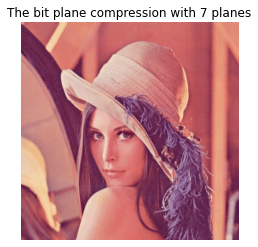

PSNR = 51.343


In [22]:
Bit_plane_1 = bit_plane(embd_image,1)
img_compress_1 = Bit_plane_1.main()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


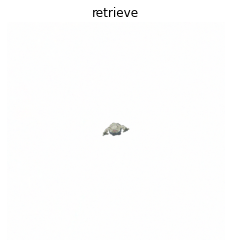

In [23]:
Retrieve_1 = retrieve_image(lena_rotate_180, img_compress_1,10)
Retrieve_1.retrieve()

Second case

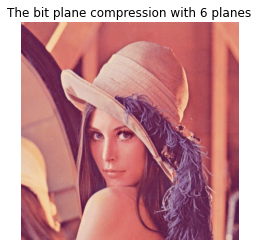

PSNR = 42.779


In [24]:
Bit_plane_2 = bit_plane(embd_image,2)
img_compress_2 = Bit_plane_2.main()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


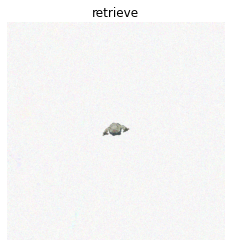

In [25]:
Retrieve_2 = retrieve_image(lena_rotate_180, img_compress_2,10)
Retrieve_2.retrieve()

Third case

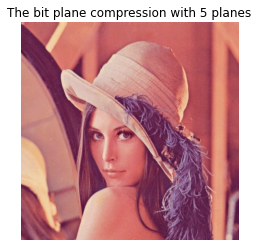

PSNR = 35.759


In [26]:
Bit_plane_3 = bit_plane(embd_image,3)
img_compress_3 = Bit_plane_3.main()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


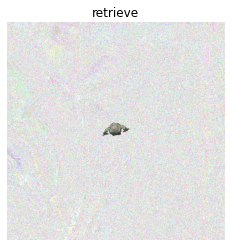

In [27]:
Retrieve_3 = retrieve_image(lena_rotate_180, img_compress_3,10)
Retrieve_3.retrieve()